# Transit Fitting

Welcome to the transit fitting tutorial of `chromatic_fitting`! In this tutorial we will go through how to create a simulated transit using the handy `chromatic` package and then fit it using the transit model (`TransitModel`) in `chromatic_fitting`.

In [42]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table

plt.matplotlib.style.use('default')

## Create Synthetic Rainbow + Transit

To create our simulated data set we will use `SimulatedRainbow()` from within `chromatic`. This creates only basic data with time and wavelength axes. Then we want to inject some noise (to make it realistic) and then inject a transit (the whole point of this tutorial). By default `chromatic` will inject a planet with Rp/R* of 0.1, but we want to make things a little more realistic so we will make the radius ratio vary linearly with wavelength.

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

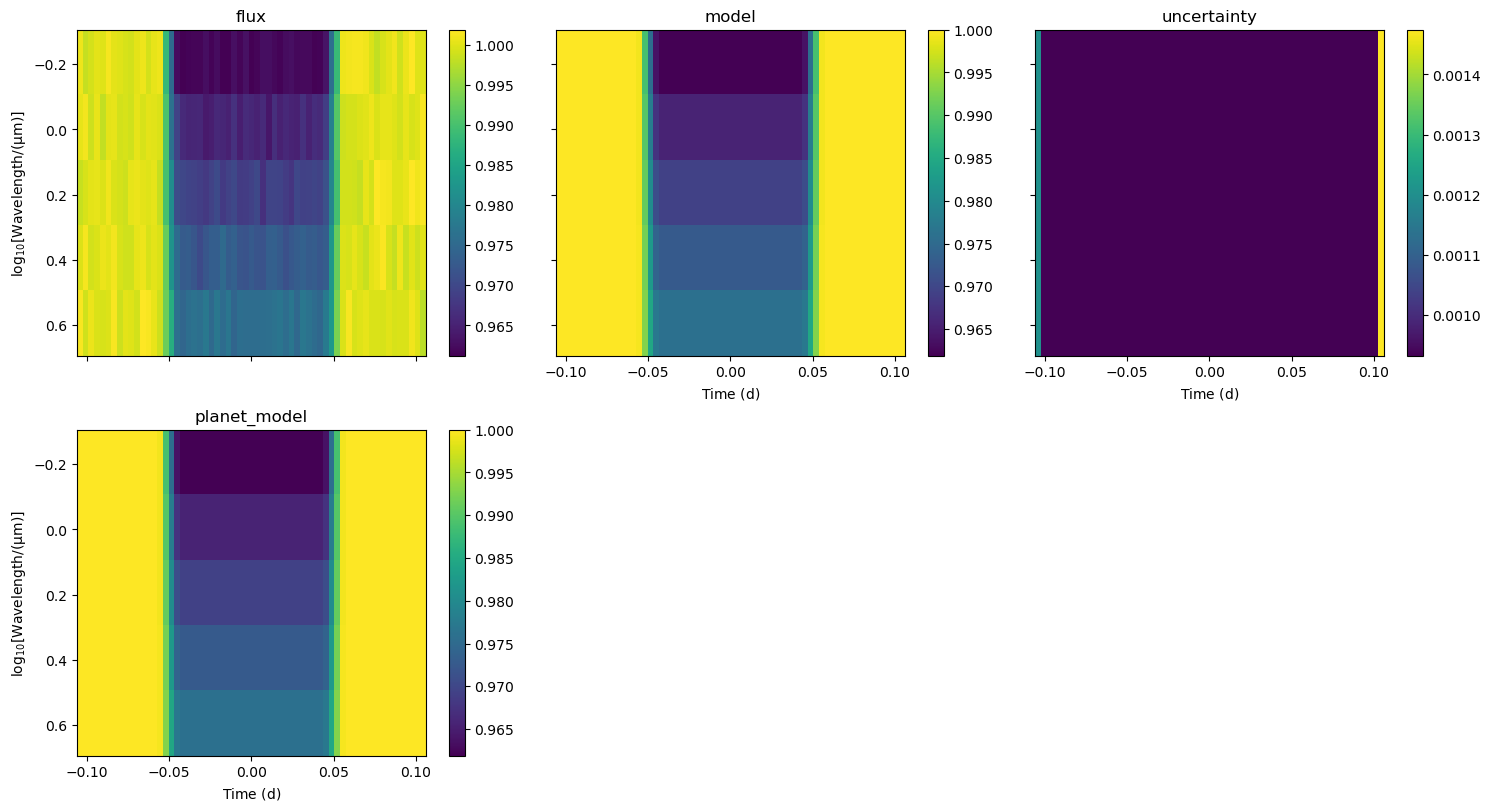

In [43]:
# create transit rainbow:
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit (with depth varying with wavelength):
r = r.inject_transit(
        method="trapezoid",
        planet_radius=np.linspace(0.2, 0.15, r.nwave),
        P=1.0,
        t0=0.0,
        baseline=1.0
    )

# bin into 10 wavelength bins:
nw = 5
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# show the simulated dataset
rb.imshow_quantities();

In [44]:
rb

<Simulated🌈(5w, 61t)>

In [45]:
r.metadata['injected_transit_parameters']

{'delta': array([0.04      , 0.03982628, 0.03965293, 0.03947996, 0.03930737,
        0.03913516, 0.03896333, 0.03879187, 0.03862079, 0.03845009,
        0.03827977, 0.03810983, 0.03794026, 0.03777108, 0.03760227,
        0.03743384, 0.03726578, 0.03709811, 0.03693081, 0.03676389,
        0.03659735, 0.03643119, 0.03626541, 0.0361    , 0.03593497,
        0.03577032, 0.03560605, 0.03544216, 0.03527864, 0.0351155 ,
        0.03495274, 0.03479036, 0.03462836, 0.03446673, 0.03430548,
        0.03414461, 0.03398412, 0.03382401, 0.03366427, 0.03350491,
        0.03334594, 0.03318733, 0.03302911, 0.03287127, 0.0327138 ,
        0.03255671, 0.0324    , 0.03224367, 0.03208771, 0.03193214,
        0.03177694, 0.03162212, 0.03146767, 0.03131361, 0.03115992,
        0.03100662, 0.03085369, 0.03070113, 0.03054896, 0.03039716,
        0.03024575, 0.03009471, 0.02994405, 0.02979376, 0.02964386,
        0.02949433, 0.02934518, 0.02919641, 0.02904802, 0.0289    ,
        0.02875236, 0.0286051 , 0.02845

## Define a PyMC3 Transit Model

Now onto `chromatic_fitting`. First we need to create a transit model.

In [46]:
# create transit model:
t = TransitModel()

Then we will want to decide how our parameters will vary. We can see the parameters that we will need to provide to the model. **Warning:** if we dont set any of these parameters then they will take on default values.

In [47]:
t.required_parameters

['stellar_radius',
 'stellar_mass',
 'radius_ratio',
 'period',
 'epoch',
 'baseline',
 'impact_parameter',
 'limb_darkening']

In [48]:
t.defaults

{'stellar_radius': 1.0,
 'stellar_mass': 1.0,
 'radius_ratio': 1.0,
 'period': 1.0,
 'epoch': 0.0,
 'baseline': 1.0,
 'impact_parameter': 0.5,
 'eccentricity': 0.0,
 'omega': 1.5707963267948966,
 'limb_darkening': [0.2, 0.2]}

Usually when we're fitting a transit we'll have some idea about the transit parameters (from previous literature or just looking at the lightcurves by eye), so it's a good idea to give good initial estimates to help our sampling converge nicely. Here we're defining the prior distributions for each parameter. There are four options for parameters in `chromatic_fitting`: `Fixed`, `WavelikeFixed`, `Fitted`, and `WavelikeFitted`. `Fixed` is one value fixed across all wavelengths, `WavelikeFixed` are fixed values that can vary between wavelengths. `Fitted` determines a prior distribution (e.g. `Uniform`, `Normal`, `TruncatedNormal`) that we will use to fit one value for the parameter across all wavelengths. Similarly, `WavelikeFitted` is a prior distribution that we will use to fit for a different value for every wavelength. 

In [51]:
# add our parameters:
t.setup_parameters(
                  period=1.0, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05), # a different value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.2,0.2], shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.05), 
                )

# print a summary of all params:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1.0 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='transit_baseline') for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 1.5707963267948966 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted Uniform(testval=[0.2, 0.2], shape=2, name='transit_limb_darkening') for each wavelength 🧮>



In [52]:
for a,b in t.parameters.items():
    print(b.name)

transit_stellar_radius
transit_stellar_mass
transit_radius_ratio
transit_period
transit_epoch
transit_baseline
transit_impact_parameter
transit_eccentricity
transit_omega
transit_limb_darkening


## Attach the Rainbow Object and Set-up the Model

The next step is to attach the actual data to the model and setup the lightcurves!

In [53]:
# attach the Rainbow object to the model:
t.attach_data(rb)

# this is the last point where we can change the optimization method:
# t.choose_optimization_method("separate")

# # setup the lightcurves for the transit model:
t.setup_lightcurves()

# # relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

  0%|          | 0/1 [00:00<?, ?it/s]

If we look at our `PyMC3` model we can see that it has a lot of parameters to optimize! If we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [54]:
print(t._pymc3_model)

         transit_epoch_interval__ ~ TransformedDistribution
transit_impact_parameter_impact__ ~ TransformedDistribution
transit_stellar_radius_interval__ ~ TransformedDistribution
  transit_stellar_mass_interval__ ~ TransformedDistribution
transit_limb_darkening_interval__ ~ TransformedDistribution
             transit_radius_ratio ~ Normal
                 transit_baseline ~ Normal
                    transit_epoch ~ Uniform
         transit_impact_parameter ~ ImpactParameter
           transit_stellar_radius ~ Uniform
             transit_stellar_mass ~ Uniform
                     transit_a_R* ~ Deterministic
           transit_limb_darkening ~ Uniform
                             data ~ Normal


We've got our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio_w{N}` and `baseline_w{N}` only. The `wavelength_{N}_data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've set `store_models = True` at the `.setup_lightcurves()` stage then we will also see a bunch of models!

Now we can plot a couple of priors (samples from our prior distribution) - do they look OK?

In [55]:
# t.plot_priors()

Plotting the priors can be reassuring for two reasons: (1) we're not giving priors that are vastly off from the true values, and (2) we're not over-constraining our model by giving it the exact solution and priors that are too tight.

Another check is does this planetary system actually transit given our parameters?

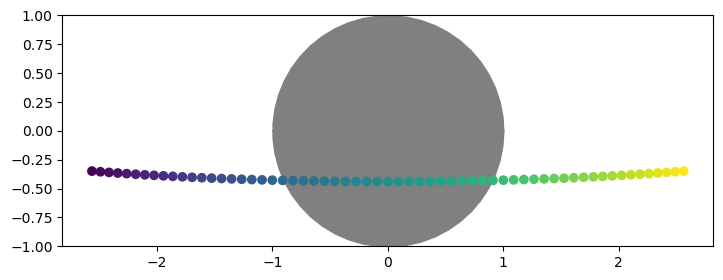

In [56]:
t.plot_orbit()
# t.orbit

Looks good! And a final check of what the actual lightcurves look like:

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


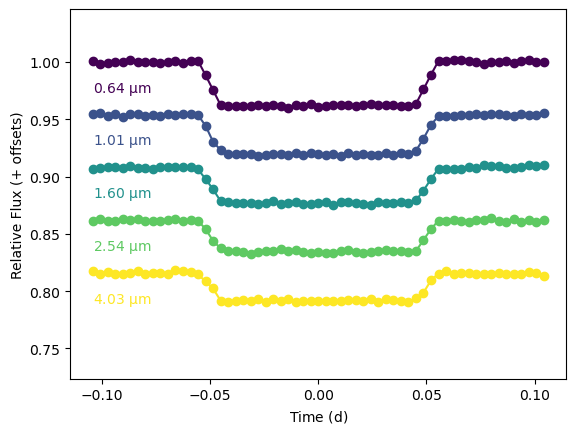

In [57]:
t.plot_lightcurves()

## PyMC3 sampling

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

In [ ]:
# optimize for initial values!
opt = t.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains. NOTE: if you do separate wavelength fitting then the number of steps 
# is per wavelengths, not divided between the wavelengths!
t.sample(start=opt, tune=2000, draws=3000, chains=4, cores=4) #start=opt, 

optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -2060322.044391754 -> -200557.33870747063


/Users/camu5866/opt/anaconda3/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:109: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


At this stage the sampler may print out some warnings that we don't have enough tuning steps! Also be aware this step can be quite slow depending on how many parameters we're trying to fit at once (which may increase with the number of wavelengths). We can then see the results of our sampling by running `.summarize()`:

In [ ]:
t.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

In [ ]:
np.all(t.summary['r_hat'].values < 1.05) # check the convergence is good!

We might also want to see a couple of posterior samples as a "quick-look" check! **But beware** if you've chosen the "separate" optimization method then it will plot the posteriors for every wavelength!):

In [ ]:
# t.plot_posteriors()

But what are the results?? We can easily see the results using the handy `.get_results()` function:

In [ ]:
t.parameters['transit_a_R*'] = []
results = t.get_results(uncertainty='sd')#['hdi_16%','hdi_84%'])

# results is a pandas dataframe, however, it doesn't show up properly on Git docs so I'll convert it to an
# astropy table
from astropy.table import Table
Table.from_pandas(results)

We can also make a transmission spectrum table using `.make_transmission_spectrum_table() `

In [ ]:
transmission_spectrum = t.make_transmission_spectrum_table(uncertainty=['hdi_16%','hdi_84%'])

Table.from_pandas(transmission_spectrum)

We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function. This can take a minute if generating the models from parameters for lots of wavelengths.

In [ ]:
models = t.get_model()
models.keys()

As the `.get_model()` process can take time to generate the models, we store the models for use later...

In [ ]:
t._fit_models.keys()

## Visualizing Results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

In [ ]:
t.plot_lightcurves()

## Check Residuals

In [ ]:
t.plot_with_model_and_residuals()

/Users/camu5866/opt/anaconda3/lib/python3.9/site-packages/chromatic/rainbows/visualizations/models/imshow_with_models.py:74: UserWarning: 'systematics_model' doesn't exist and will be skipped.
  warnings.warn(f"'{m}' doesn't exist and will be skipped.")


TypeError: Image data of dtype object cannot be converted to float

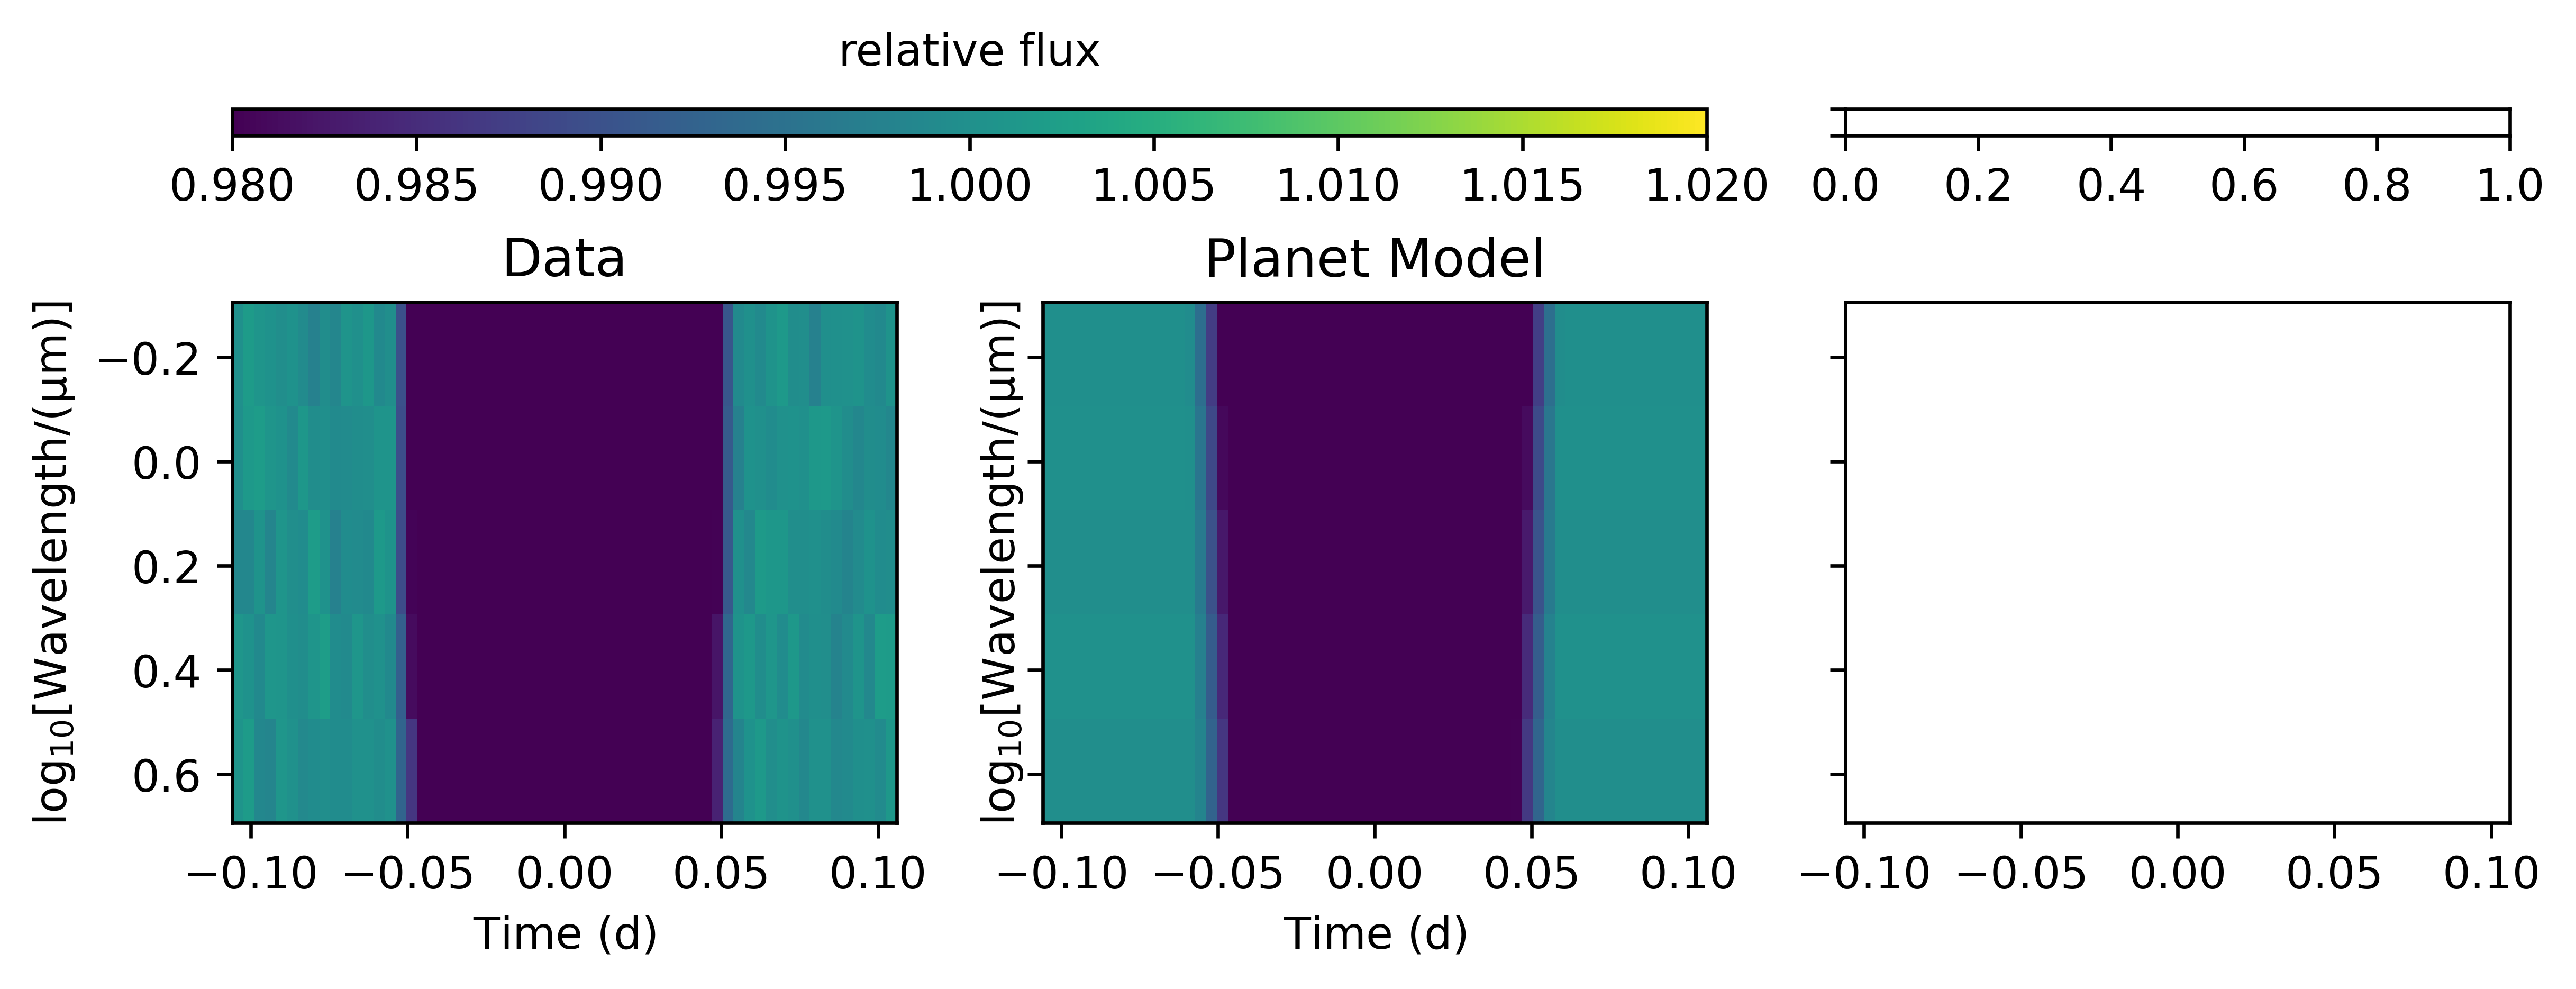

In [36]:
t.imshow_with_models()

## Plot the Transmission Spectrum

We can also plot the transmission spectrum (and we know what the true values are):

In [ ]:
t.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'])
plt.plot(r.wavelength, np.sqrt(rb.metadata['injected_transit_parameters']['delta']), label="True Rp/R*")

plt.legend();

In [ ]:
t.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'])
plt.plot(r.wavelength, rb.metadata['transit_parameters']['rp_unbinned'], label="True Rp/R*")
plt.title("Separate Wavelength Fitting")
plt.legend();

/Users/camu5866/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


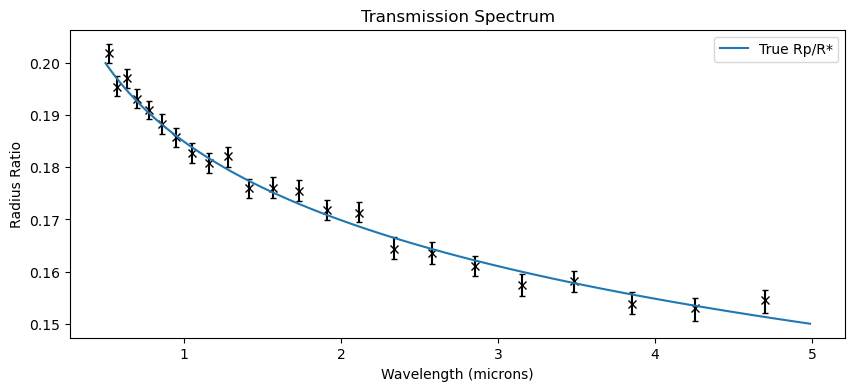

In [81]:
t.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'])
plt.plot(r.wavelength, rb.metadata['transit_parameters']['rp_unbinned'], label="True Rp/R*")

plt.legend();